In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

## Prepare dataset

- extract 30% from train folder to eval

In [19]:
import glob
import os
import random


for filename in glob.glob('data/train/Input/*.png'): 
    
    # modify string to get file name for lables
    filename_label1 = filename.replace("Input", "Label1")
    filename_label2 = filename.replace("Input", "Label2")
    
    if random.random() > 0.3:
        # move 70% of data into train folder
        os.rename(filename, filename.replace("Input", "Input/train"))
        os.rename(filename_label1, filename_label1.replace("Label1", "Label1/train"))
        os.rename(filename_label2, filename_label2.replace("Label2", "Label2/train"))
        
    else: # move 30% into eval folders
        os.rename(filename, filename.replace("Input", "Input/eval"))
        os.rename(filename_label1, filename_label1.replace("Label1", "Label1/eval"))
        os.rename(filename_label2, filename_label2.replace("Label2", "Label2/eval"))
    

In [31]:
print(len([name for name in os.listdir('./data/train/Input/train')]))
print(len([name for name in os.listdir('./data/train/Input/eval')]))
# [name for name in os.listdir('./data/train/Input/train')] == [name for name in os.listdir('./data/train/Label2/train')]

1622
653


In [32]:
653/1622

0.40258939580764486

In [62]:
## verification
!python -m keras_segmentation verify_dataset \
 --images_path="./dataset/train" \
 --segs_path="./dataset/ann"  \
 --n_classes=2

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 15.08it/s]
Dataset verified! 


## Preprocessing

In [114]:
!tree "./dataset"

./dataset
├── Input
│   ├── eval
│   └── train
├── Label1
│   ├── eval
│   └── train
└── Label2
    ├── eval
    └── train

9 directories, 0 files


In [115]:
directory = "./data/train/"
for root, subdirectories, files in os.walk(directory):
#     for subdirectory in subdirectories:
#         print(os.path.join(root, subdirectory))
    for file in files:
        if file.endswith(".png"):        
            with Image.open(os.path.join(root, file)) as x:
                img = normalize(np.asarray(x), norm="max")
                filename = os.path.join(root, file).replace("data/train", "dataset")
                cv2.imwrite(filename, img)

In [116]:
!python -m keras_segmentation verify_dataset \
 --images_path="dataset/Input/train/" \
 --segs_path="dataset/Label1/train/"  \
 --n_classes=2

100%|███████████████████████████████████████| 1622/1622 [00:24<00:00, 65.46it/s]
Dataset verified! 


In [117]:
!python -m keras_segmentation verify_dataset \
 --images_path="dataset/Input/eval/" \
 --segs_path="dataset/Label2/eval/"  \
 --n_classes=2

100%|█████████████████████████████████████████| 653/653 [00:10<00:00, 64.69it/s]
Dataset verified! 


(960, 960)


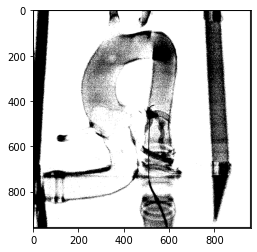

In [122]:
## Visualisation
file = "./dataset/Input/train/0001.png"
with Image.open(file) as x:
    plt.imshow(np.asarray(x), cmap="gray")
    print(np.asarray(x).shape)

## Load data

In [2]:
data  = np.load('train_data.npz')

In [3]:
# sorted(data)
X = data["X"]
y= data["y1"]

## Preprocessing

In [4]:
y = y/255

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X[:200], y[:200], test_size=0.33, random_state=42)

## Model training

In [6]:
input_height = 960
input_width = 960
n_classes = 2

In [7]:
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers

from tensorflow.keras import optimizers
from tensorflow.keras import callbacks

In [8]:
#### 1. ARCHITECTURE
model_pipe = Sequential([
    layers.Reshape((input_width, input_height, 1), input_shape=(input_width, input_height)),
    layers.experimental.preprocessing.Rescaling(scale=1./60300.),
    layers.Conv2D(16, (3,3), padding='same', activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(32, (2,2), padding='same', activation="relu"),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Dropout(0.3),
    layers.Conv2DTranspose(filters=1, kernel_size=3, strides=4, padding='same'),
    layers.Conv2D(1, (1,1), padding='same', activation="sigmoid")
    
])
model_pipe.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 960, 960, 1)       0         
                                                                 
 rescaling (Rescaling)       (None, 960, 960, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 960, 960, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 480, 480, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 480, 480, 32)      2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 240, 240, 32)     0         
 2D)                                                    

2022-05-18 20:59:33.862695: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
#### 2. COMPILATION
# adam_opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

# Classification with 2 classes
model_pipe.compile(loss='binary_crossentropy', 
              optimizer='sgd',
              metrics=[tf.keras.metrics.IoU(num_classes=2, target_class_ids=[1]),
                      "accuracy", ])


## checkpoint
checkpoint_path = "checkpoint_dir"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

#### 3. FIT
es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

model_pipe.fit(X_train, y_train,
          batch_size=16, # When batch size is too small --> no generalization
          epochs=10,    # When batch size is too large --> slow computations
          validation_data=(X_test, y_test),
          callbacks=[es],
          verbose=0)

KeyboardInterrupt: 

In [4]:
from tensorflow.keras import *
from tensorflow.keras.layers import *


img_input = Input(shape=(input_height,input_width, 1))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D((2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

up1 = concatenate([UpSampling2D((2, 2))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

up2 = concatenate([UpSampling2D((2, 2))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

out = Conv2D(1, (1, 1) , padding='same')(conv5)



# model = get_segmentation_model(img_input ,  out ) # this would build the segmentation model

## VGG_UNET